In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from copy import deepcopy

In [2]:
from brian2 import *
%matplotlib inline
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools

#to compute classification metrics
from sklearn.metrics import f1_score as fs
from sklearn.metrics import confusion_matrix

#for mnist data
from keras.datasets import mnist
from scipy.ndimage import interpolation

## Integrate-and-fire neuron model

This is one of the simplest models of neuron behavior. It omits all the intricacies of what goes on electrochemically inside the neuron's body, and simply attempts to capture the basic 'accumulate till a threshold and then fire and let go of all the accumulation' aspect of a neuron's activity 

$$\frac{dv}{dt} = \frac{(v_0 - v)}{\tau},$$

where $v$ is the membrane voltage of the neuron, and $\tau$ is a timescale factor.

In [3]:
v0 = 1
tau = 10*ms
eqs = '''
dv/dt = (v0-v)/tau : 1
'''

In [4]:
G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')
M = StateMonitor(G, 'v', record=True)
spikemon = SpikeMonitor(G)

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Text(0, 0.5, 'v')

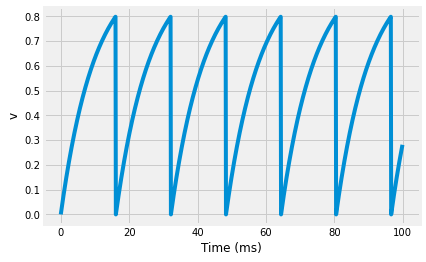

In [5]:
run(100*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v')

## Hopfield network model

In this simplified Hopfied model, each neuron can only take values +1 or -1. The network stores pixel patterns, and attempts to retrieve them given some cue in the form of a part of the original pattern used to set an initial state $S_i(t=0)$ for every neuron in the network. The network activation of all the neurons evolves as follows

$$S_i(t+1) = sgn\left(\sum_j{w_{ij} S_j(t)}\right), $$

where the weight of every synaptic connection is calculated as,

$$w_{ij} = \frac{1}{N} \sum_{\mu}{p_i^\mu p_j^\mu}, $$

where in turn, $N$ is the number of neurons, and $p_i^\mu$ is the state of the $i^{th}$ neuron for encoding pattern $\mu$.

The code below is taken from this [link](https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hopfield-network.html). Follow the accompanying exercises to be better prepared for your assignment. Remember to install all needed libraries before trying to run it. 

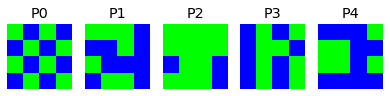

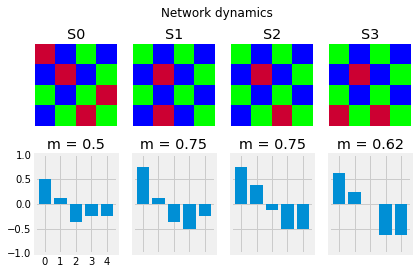

In [6]:
pattern_size = 4

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)
# instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
# create a checkerboard pattern and add it to the pattern list
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard]

# add random patterns to the list
pattern_list.extend(factory.create_random_pattern_list(nr_patterns=4, on_probability=0.5))
plot_tools.plot_pattern_list(pattern_list)
# how similar are the random patterns and the checkerboard? Check the overlaps
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
#plot_tools.plot_overlap_matrix(overlap_matrix)

# let the hopfield network "learn" the patterns. Note: they are not stored
# explicitly but only network weights are updated !
hopfield_net.store_patterns(pattern_list)

# create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=4)
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=3)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = factory.reshape_patterns(states)
# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")


## Assignment 1

Q1. Can you write you own Hopfield network model that works more or less like the one simulated above? (20 points)

Q2. Run the model with different parameters to figure out how the model's capacity to retrieve the correct pattern in response to a cue deteriorates as a function of 
(a) the informativeness of the cue
(b) the number of other patterns stored in the network
(c) the size of the network

Present your answers with plots and/or math. (20 points)

Q3. Can you write a function that converts MNIST digit [data](https://gitlab.com/datapythonista/mnist) to the sort of patterns used in this simulation? (20 points)

Q4. Can you write an MNIST classifier using the Hopfield network?. Can you characterize its performance using F-score, and compare with [classical](https://github.com/ksopyla/svm_mnist_digit_classification) and [deep](https://github.com/hwalsuklee/tensorflow-mnist-cnn) supervised learning methods? Remember that you can always use multiple samples of the same digit even for the Hopfield network classifier. Summarize your sense of the merits and demerits of using a Hopfield network as a classifier (40 points) 

# Question 1 :  Our own Hopfield network model

In [7]:
#function to get randomly generated patterns
#args: size of each pattern , no of patterns

def get_patterns(no_of_neurons,no_of_patterns):
    
    #list to store patterns
    pattern_list = []
    
    
    for i in range(no_of_patterns):
        
        #generating random pattern with values  0 and 1
        present_pattern= np.random.binomial(1, 0.5, no_of_neurons * no_of_neurons)
        
        #converting into -1 and +1 representation
        present_pattern= present_pattern* 2 - 1 
        
        #reshaping of pattern
        present_pattern=present_pattern.reshape((no_of_neurons, no_of_neurons))
        
        #appending the pattern into pattern list
        pattern_list.append(present_pattern)
        
    #returning the pattern list
    return pattern_list

In [8]:
#function to add noise into the pattern
#args: pattern,no of noise values

def perturb_pattern(pattern, no_of_flips):
    
    #getting total no of neurons
    total_neurons = np.prod(pattern.shape)
    
    #getting indices (without replacement) to add noise
    reassignment_neurons = np.random.choice(total_neurons, no_of_flips, replace=False)
    
    #flattening the pattern
    linear_pattern = pattern.flatten()
    
    #flipping the values of selected indices
    linear_pattern[reassignment_neurons] = -linear_pattern[reassignment_neurons]
    
    #returning the modified pattern
    return linear_pattern.reshape(pattern.shape)

In [9]:
#function to calculate weights of hopfield network
#args: pattern list

def calculate_weights(pattern_list):
    
    #getting total no of neurons
    neurons=pattern_list[0].shape[0]
    total_neurons=neurons*neurons
    
    #initializing the weight matrix
    weights = np.zeros((total_neurons, total_neurons))
    
    #formula to compute the weights
    
    #for each pattern in pattern list
    for pattern in pattern_list:
        
        #flatenning the pattern
        linear_pattern = pattern.flatten()
        
        #for each neuron
        for i in range(total_neurons):
            
            #for each neuron
            for j in range(total_neurons):
                
                #updating the weight of neuron i and neuron j
                weights[i, j] += linear_pattern[i] *linear_pattern[j]
                
    #diving weight matrix by total neurons
    weights /= total_neurons
    
    # filling self connections values with 0
    np.fill_diagonal(weights, 0)
    
    #returning weight matrix
    return weights

In [10]:
#function for network evolution
#args:input state,weight matrix

def network_evolution(state_s0, weights):
    
    #flattening the input state
    state_s0=state_s0.flatten()
    
    #initializing the next state
    next_state=state_s0.copy()
    
    #for each neuron
    for i in range(len(state_s0)):
        
        #to store the summation value of that neuron
        summation=0
        
        #formula to calculate the next state of the neuron
        for j in range(len(weights)):
            summation+=weights[i][j]*state_s0[j]
        next_state[i]=sign(summation)
    
    #returning the next state
    return next_state

In [11]:
#function to reshape the patterns in a given list
#args:list of patterns(flat patterns)

def reshape_list(l):
    
    #getting the root of the total no of neurons in a pattern
    n=int(sqrt(l[0].shape[0]))
    
    #for each pattern in the list
    for i in range(len(l)):
        
        #reshaping the pattern
        l[i]=np.reshape(l[i],(n,n))
        
    #returning the reshaped list
    return l

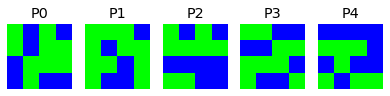

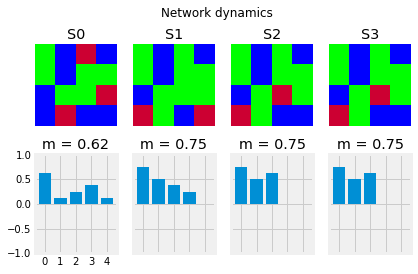

In [12]:
#getting list with 5 patterns
plist = get_patterns(4,5)

#plotting the patterns
plot_tools.plot_pattern_list(plist)


cue = deepcopy(plist)

#adding noise to the initial pattern
S = perturb_pattern(cue[0],3)

#flattening the pattern
S=S.flatten()

#storing the pattern size
#pattern_size=16

#getting network weights
wghts = calculate_weights(plist)

#to store the states that network goes through
state_list =[S]

#repeating the network evolution 3 times
for i in range(3):
    
    #appending the next state of network into state list
    S=network_evolution(S,wghts)
    state_list.append(S)

#reshaping the state list
state_list = reshape_list(state_list)

#plotting the states of the network
plot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx=0, suptitle="Network dynamics")

# Question 2 : model's capacity to retrieve the correct pattern in response to a cue deteriorates

In [13]:
#function to compute the overlap score between two patterns
#args:pattern1 , pattern2

def compute_overlap(pattern1, pattern2):
    
    #checking if the shapes of two patterns match
    shape1 = pattern1.shape
    
    #raising error if the shapes dont match
    if shape1 != pattern2.shape:
        raise ValueError("patterns are not of equal shape")
        
    #computing the dot product btw the two patterns
    dot_prod = np.dot(pattern1.flatten(), pattern2.flatten())
    
    #returning the overlap score
    return float(dot_prod) / (np.prod(shape1))

## Q2.a : models capacity as a function of informativess of cue

In [14]:
#function to change the informativess of cue and return the overlap score 
#args:no of neurons that are not flipped(informativess) , pattern list

def informativeness(info_of_cue,plist):
    
    cue = deepcopy(plist)
    
    
    #adding noise to the initial pattern
    #noise=total neurons-informative neurons
    S = perturb_pattern(cue[0],np.prod(np.shape(plist[0]))-info_of_cue)

    #flattening the pattern
    S=S.flatten()

    #repeating the network evolution 10 times
    for i in range(10):
        
        #getting the updated state
        S=network_evolution(S,wghts)
    
    #returning the overlap score btw the original pattern and the final network state
    return compute_overlap(plist[0].flatten(),S)
    

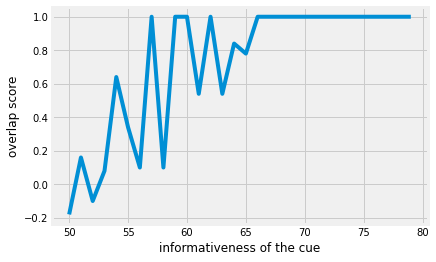

In [15]:
#getting pattern list
plist = get_patterns(10,5)

#computing weights
wghts=calculate_weights(plist)
#to store informativeness of cue and the corresponding overlap score
x=[]
y=[]

#running through different values of informativeness
for i in range(50,80):
    
    #appending informativeness of cue to x
    x.append(i)
    
    #appending overlap score to y
    y.append(informativeness(i,plist))
    
#plotting x vs y
plt.plot(x, y)
plt.xlabel("informativeness of the cue")
plt.ylabel("overlap score")
plt.show()

### we can observe that as the informativeness of cue  increases the overlap score also increases or stays constant,so the models capacity to retrieve correct pattern increases

### the graph is not  increasing at some points ,this may be  due to flipping  performed randomly on different neurons due to which the cue pattern changes,ignoring those flipping, roughly we can say that the models capacity to retrieve correct pattern increases

##  Q2.b : models capacity as a function of the number of other patterns stored in the network 

In [16]:
#function to add a new pattern to the pattern list and return the overlap score

def add_pattern():
    
    #getting the new pattern
    plist_new = get_patterns(10,1)
    
    #adding the pattern to plist
    plist.extend(plist_new)
    
    #computing weights on the updated pattern list
    wghts = calculate_weights(plist)
    
    cue = deepcopy(plist)
    
    #adding noise to the initial pattern
    S = perturb_pattern(cue[0],40)

    #flattening the pattern
    S=S.flatten()

    #repeating the network evolution 10 times
    for i in range(10):
        
        #getting the updated state
        S=network_evolution(S,wghts)
        
    #returning the overlap score btw the original pattern and the final network state
    return compute_overlap(plist[0].flatten(),S)
    

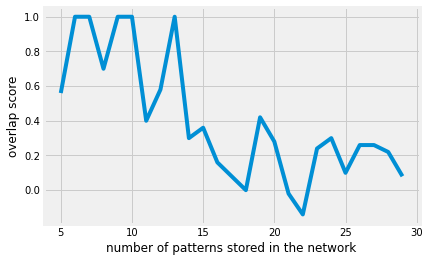

In [17]:
#getting pattern list
plist = get_patterns(10,4)

#to store the number of patterns stored in the network and the corresponding overlap score
x=[]
y=[]

#running through different values of number of patterns stored in the network
for i in range(5,30):
    
    #appending no of patterns stored into x
    x.append(i)
    
    #appending overlap score into y
    y.append(add_pattern())
    
#plotting x vs y
plt.plot(x,y)
plt.xlabel("number of patterns stored in the network")
plt.ylabel("overlap score")
plt.show()

# we can observe that as the number of patterns stored in the network  increases the overlap score decreases or stays constant,so the models capacity to retrieve correct pattern decreases

### the graph is not  decreasing at some points ,this may be  due to the added pattern might be closely related to the initial pattern,ignoring those points, roughly we can say that the models capacity to retrieve correct pattern decreases

##  Q2.c : models capacity as a function of size of the network

In [18]:
#function to get newtroks of different sizes and return the overlap score
#args:no of neurons

def network_size(nfn):
    
    #getting the pattern list
    plist = get_patterns(nfn,5)
    
    #computing the network weights
    wghts = calculate_weights(plist)

    cue = deepcopy(plist)
    
    #adding noise to the initial pattern
    S = perturb_pattern(cue[0],5)

    #flattening the pattern
    S=S.flatten()
    
    #repeating the network evolution 20 times
    for i in range(20):
        
        #getting the next state
        S=network_evolution(S,wghts)
    
    #returning the overlap score btw the original pattern and the final network state
    return compute_overlap(plist[0].flatten(),S)

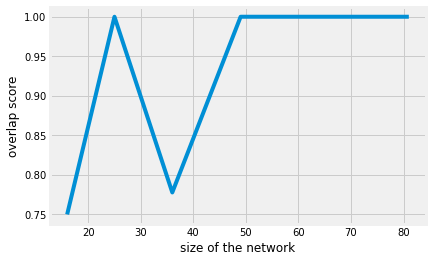

In [19]:
#lists to store the size of the network and the overlap scores
x=[]
y=[]

#lopping through different network sizes
for i in range(4,10):
    
    #appending the network size into x
    x.append(i*i)
    
    #appending the overlap score into y
    y.append(network_size(i))
    
#plotting x vs y
plt.plot(x,y)
plt.xlabel("size of the network")
plt.ylabel("overlap score")
plt.show()

### we can observe that as the size of the network increases the overlap score increases or stays constant,so the models capacity to retrieve correct pattern increases

# Question3 : function to convert MNIST digit data to the sort of patterns used in our simulation

### theory  behind performing all these pre transformations is this research paper:https://www.researchgate.net/publication/341712078_Classification_of_handwritten_digits_using_the_Hopfield_network

In [20]:
#functions to deskew a given image
#src:https://stackoverflow.com/questions/43577665/deskew-mnist-images
#when given a image deskew function returns the deskewed image

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix
def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    img = interpolation.affine_transform(image,affine,offset=offset)
    #return (img - img.min()) / (img.max() - img.min())
    return img

In [21]:
#function that takes mnist test and train data and convertss into format suitable for hopfield network

def mnist_converter(x_train,x_test):
    
    #deskewing train data
    for i in range(len(x_train)):
        x_train[i]=deskew(x_train[i])
    
    #deskewing test data
    for i in range(len(x_test)):
        x_test[i]=deskew(x_test[i])
    
    #computing the average image of each digit in train data and storing them in a list
    avg_list=[]
    for i in range(10):
        avgImg = np.average(x_train[y_train==i],0)
        avg_list.append(avgImg)
    
    #converting test data into list
    x_test_list=[]
    for i in range(len(x_test)):
        x_test_list.append(x_test[i])
    
    
    #converting 28*28 data into 14*14(since the outer pixels have the same values for all patterns,they induce correlation)
    rem_list=[]
    for i in range(len(avg_list)):
        curr_list=[]
        for j in range(7,21):
            curr_list.extend(avg_list[i][j][7:21])
        curr_list=np.reshape(curr_list,(14,14))
        rem_list.append(curr_list)
    
    #converting test data into 14*14
    x_test_list_final=[]
    for i in range(len(x_test_list)):
        curr_list=[]
        for j in range(7,21):
            curr_list.extend(x_test_list[i][j][7:21])
        curr_list=np.reshape(curr_list,(14,14))
        x_test_list_final.append(curr_list)
    
    
    #converting grey scale values into +1 and -1 using threshold as 86
    for i in range(len(rem_list)):
        rem_list[i]=np.sign(rem_list[i]-86)#np.mean(avg_list[i]))
    for i in range(len(x_test_list_final)):
        # Thresholding
        thresh = 86
        binary = x_test_list_final[i] > thresh
        shift = 2*(binary*1)-1 # Boolian to int
    
        # Reshape
        x_test_list_final[i]=shift
    
    #returning the pattern list and the test list
    return rem_list,x_test_list_final

# Question4 : implementing MNIST classifier using the Hopfield network

In [22]:
#reading the data
(x_train, y_train), (x_test,y_test)= mnist.load_data()

In [23]:
#converting the mnist data into suitable format for hofield network
p_list,test_list=mnist_converter(x_train,x_test)

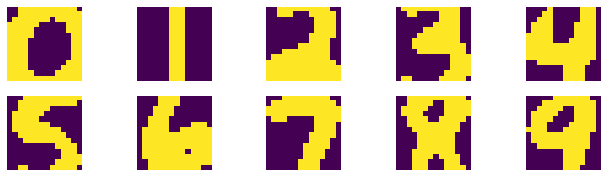

In [24]:
#plotting the pattern list after transformation
plt.figure(figsize=(10,3))
for i in range(10):
    avgImg = p_list[i]
    #avg_list.append(avgImg)
    plt.subplot(2, 5, i+1)
    plt.imshow(avgImg.reshape((14,14))) 
    plt.axis('off')

In [25]:
#computing the weights of network 
wghts=calculate_weights(p_list)

### this code segment might take upto 10 mins, please have patience

In [26]:
#list to store the final states of each test sample
s_final=[]

#running for first all test images
for i in range(len(test_list)):
    
    #flattening the pattern
    S=test_list[i].flatten()
    
    #running network evolution for 1 time
    for k in range(1):
        S=network_evolution(S,wghts)
        
    #appending the final state into list
    s_final.append(S)

In [27]:
#converting the pattern list and state list into arrays of flattened values

#first storing the flattened values in lists
fsl=[]
fpl=[]
for i in range(len(p_list)):
    fpl.append(p_list[i].flatten())
for i in range(len(s_final)):
    fsl.append(s_final[i].flatten())
    
#second converting the lists into arrays
fsl=np.array(fsl)
fpl=np.array(fpl)

In [28]:
#computing the overlap scores between the final states of each test sample and each train pattern
overlap_scores=np.dot(fsl,fpl.T)

In [29]:
#getting the predicted digit of each test sample
y_pred=list(overlap_scores.argmax(1))

## calculating the f score and comparing with other methods

In [30]:
#calculating the f score
print(fs(y_test,y_pred, average='micro'))

0.6877


In [31]:
#printing the confusion matrix
print(confusion_matrix(y_test, y_pred))


[[ 837   59    1    6    4   13   30    6    2   22]
 [   0 1113    0    8    0    1    0    3    7    3]
 [  38  175  574   67   21    1   12   38   35   71]
 [   7  151   12  706    1   32    0    6   52   43]
 [  26   37    6    2  274    3   17    1    5  611]
 [  32   82    2   49    2  566   13   21   17  108]
 [  86   73   22    6   12   39  697    1    7   15]
 [  11   88   19    1    1    1    0  662    1  244]
 [  26   29    1   88   13   39   11    7  537  223]
 [  25   16    2    3   30    8    1    9    4  911]]


### f score of classical machine learning methods on mnist data classification is 0.98
### src:https://github.com/ksopyla/svm_mnist_digit_classification

### f score of deep learning methods on mnist data classification is 0.99
### src1:https://github.com/hwalsuklee/tensorflow-mnist-cnn
### src2:https://paperswithcode.com/sota/image-classification-on-mnist

### merits :
#### 1.very fast
#### 2. useful only when there is not much of correlation between the input patterns
### demerits:
#### 1.Much worse performance compared to other methods.
#### 2.only certain patterns can be retrieved by the network
#### 3.correlation between the input patterns affects the network heavily